# Os dados

Para coletar os dados de outros paÃ­ses, foram utilizadas as APIs dos sites:

- [About Corona](https://about-corona.net/dashboard/)
- [Europe RestFul](https://restcountries.eu/)

In [1]:

import requests
import pandas as pd

covid_api = 'https://corona-api.com/countries/'
rest_countries = 'https://restcountries.eu/rest/v2/alpha/'
country = 'IT' # Alpha-2 ISO3166

data_json =  requests.get(covid_api + country).json()
country = requests.get(covid_api + country).json()

N = country['data']['population']

print(country['data']['name'])


Italy


### Organizando os dados

In [2]:

from datetime import datetime

df = pd.DataFrame(data_json['data']['timeline'])
df = df.sort_values('date').reset_index()

from datetime import datetime, timedelta
df['date'] = [datetime.fromisoformat(f) for f in df['date']]
df = df.drop_duplicates(subset='date', keep = 'last')

# Criando o vetor de tempo
first_date = df['date'].iloc[0]
size_days = (df['date'].iloc[-1] - df['date'].iloc[0]).days
date_vec = [first_date + timedelta(days=k) for k in range(size_days)]

new_df = pd.DataFrame(date_vec, columns=['date'])
new_df = pd.merge(new_df, df, how='left', on= 'date')
new_df = new_df.drop(columns= ['index',  'updated_at', 'is_in_progress'])

for col in new_df.columns[1:]:
    new_df[col] = new_df[col].interpolate(method='polynomial', order=1)
df = new_df.dropna()

df.head()


date  deaths  confirmed    active  recovered  new_confirmed  \
0 2020-01-30     0.0   2.000000  2.000000        0.0       2.000000   
1 2020-01-31     0.0   2.000000  2.000000        0.0       0.000000   
2 2020-02-01     0.0   2.142857  2.142857        0.0       0.142857   
3 2020-02-02     0.0   2.285714  2.285714        0.0       0.285714   
4 2020-02-03     0.0   2.428571  2.428571        0.0       0.428571   

   new_recovered  new_deaths  
0            0.0         0.0  
1            0.0         0.0  
2            0.0         0.0  
3            0.0         0.0  
4            0.0         0.0

### Visualizando os dados

In [3]:
import numpy as np
from datetime import datetime

# Creating the time vector for plotly
datetime_64 = df["date"].values
ts = (datetime_64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
time = [datetime.utcfromtimestamp(t) for t in ts]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  


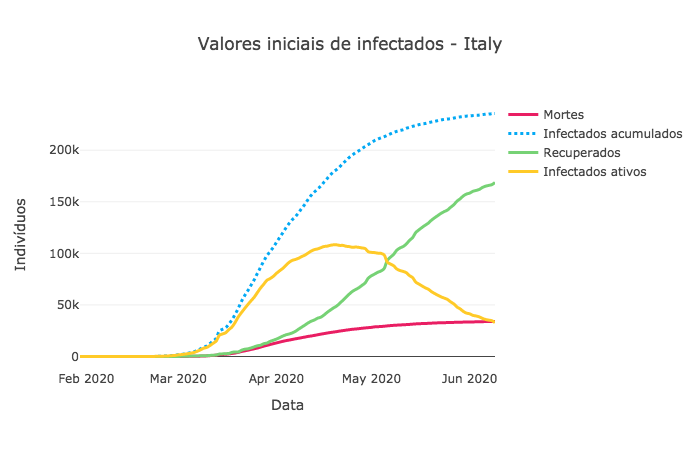

In [4]:

import plotly.graph_objects as go

first = -1

figure = go.Figure()
figure.add_trace(go.Scatter(
                    x=time[:first], 
                    y=df["deaths"].values[:first],
                    mode='lines',
                    line_shape='spline',
                    name = "Mortes",
                    line = dict(color='#e91e63', width=3)))
figure.add_trace(go.Scatter(
                    x=time[:first], 
                    y=df["confirmed"].values[:first],
                    mode='lines',
                    line_shape='spline',
                    name = "Infectados acumulados",
                    line = dict(color='#03a9f4', width=3, dash="dot")))
figure.add_trace(go.Scatter(
                    x=time[:first], 
                    y=df["recovered"].values[:first],
                    mode='lines',
                    line_shape='spline',
                    name = "Recuperados",
                    line = dict(color='#76d275', width=3)))
figure.add_trace(go.Scatter(
                    x=time[:first], 
                    y=df["active"].values[:first],
                    mode='lines',
                    line_shape='spline',
                    name = "Infectados ativos",
                    line = dict(color='#ffca28', width=3)))

figure.update_layout(template='xgridoff',
                  xaxis_title='Data',
                  yaxis_title='IndivÃ­duos',
                  title_text="Valores iniciais de infectados - " + country['data']['name'])
# 'ggplot2', 'seaborn', 'simple_white', 'plotly',
# 'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
# 'ygridoff', 'gridon', 'none'

figure.show(renderer="png")


## Verificando os dados

Verificando se o valor acumulado dos infectados $\int I(t)$ Ã© igual a relaÃ§Ã£o aprensetada no grÃ¡fico:

In [5]:

dif_I = np.diff(df['active'])
cum = []
cum.append(dif_I[0])

for k, i in enumerate(dif_I):
    cum.append(cum[-1] + i)
    
cum = np.array(cum)
cum += df['deaths'].to_numpy() + df['recovered'].to_numpy()

print("Erro entre casos acumulados e valores de confirmados: {}".format(
        round(sum((cum - df['confirmed'].values)**2 / len(cum)),2) ) ) 


Erro entre casos acumulados e valores de confirmados: 4.0


## Encontrando o inÃ­cio da epidemia

Encontrando o inÃ­cio da epidemia para eliminar dados nÃ£o informativos.

In [6]:

# Moment where cases are bigger than 2000...
start_moment = np.argmax(df["active"].to_numpy() >= 2000)


## Criando os dados SIR

In [7]:

time_ref = time[start_moment:]
I = df['active'].to_numpy()[start_moment:]
R = df['recovered'].to_numpy()[start_moment:]
M = df['deaths'].to_numpy()[start_moment:]
S = N - R - I

# Creating the time vector
t = np.linspace(0, len(I), len(I))

Sd, Id, Md, Rd, td = S, I, M, R, t


## Encontrando o pico da epidemia

Encontrando o pico da epidemia para comparaÃ§Ãµes futuras.

In [8]:

from PyAstronomy import pyasl

# Compute the derivative of the smoothed 
# active infected time series
dI = np.gradient(pyasl.smooth(I, 13, "hamming"))
t = np.linspace(0, len(dI), len(dI))

# Find the derivative bigger then zero
signal = np.array([di >= 0 for di in dI[::-1]])

# Find the first point where the derivative
# change signal
peak_pos = len(Id) - np.argmax(signal)
print("O pico da epidemia aconteceu no dia {} do comeÃ§o da epidemia, ou {}.".format(
    peak_pos, time_ref[peak_pos].strftime("%d %b %Y")))


O pico da epidemia aconteceu no dia 49 do comeÃ§o da epidemia, ou 21 Apr 2020.


# Estimando utilizando todos os dados

In [9]:

from models import *

dataset = dict(S=Sd, I=Id, R=Rd)

# Create the model
sir_model = ss.SIR(pop=N, focus=["S", "I", "R"])

# Adjust the parameters
sir_model.fit(dataset, td,
              search_pop=True,
              pop_sens=[0.001,0.01],
              Ro_sens=[0.8, 15], 
              D_sens=[5, 60])

# Predict the model
sim_res = sir_model.predict((Sd[0],Id[0], Rd[0]), td)


Loading BokehJS ...

	 â”œâ”€ S(0) â”€ I(0) â”€ R(0) â”€  [60337905.0, 2263.0, 160.0]
	 â”œâ”€ Ro bound â”€   0.8  â”€  15
	 â”œâ”€ D  bound â”€   5  â”€  60
	 â”œâ”€ equation weights â”€   [1.660934913845834e-08, 1.5228048786709021e-05, 1.4791908175384106e-05]
	 â”œâ”€ Running on â”€  differential_evolution SciPy Search Algorithm
	 â””â”€ Defined at:  6.916497609795393  â”€  41.11408931426849 



In [10]:

print("ParÃ¢metros estimados: ", sir_model.parameters)
print("Suposto Ro: ", sir_model.parameters[0])
print("Valores de beta: {}, e r: {}".format(
    sir_model.parameters[0]/sir_model.parameters[1], 1/sir_model.parameters[1]))
print("Dias contaminados: ", sir_model.parameters[1])


ParÃ¢metros estimados:  [6.91649761e+00 4.11140893e+01 3.19128042e-03]
Suposto Ro:  6.916497609795393
Valores de beta: 0.1682269442216503, e r: 0.024322562330304463
Dias contaminados:  41.11408931426849


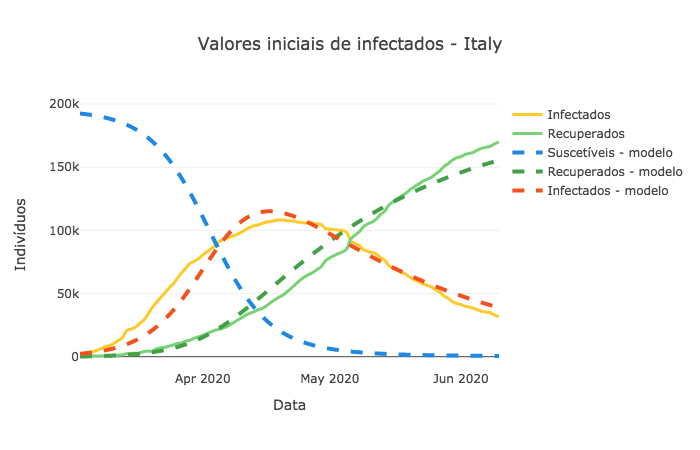

In [11]:

figure = go.Figure()
figure.add_trace(go.Scatter(
                    x=time_ref, 
                    y=I,
                    name="Infectados",
                    mode='lines',
                    line_shape='spline',
                    line = dict(color='#ffca28', width=3)))
figure.add_trace(go.Scatter(
                    x=time_ref,
                    y=R,
                    name="Recuperados",
                    mode="lines",
                    line_shape="spline",
                    line=dict(color='#76d275', width=3)))
figure.add_trace(go.Scatter(
                    x=time_ref,
                    y=sim_res[0],
                    name="SuscetÃ­veis - modelo",
                    mode="lines",
                    line_shape="spline",
                    line=dict(color="#1e88e5", width=4, dash="dash")))
figure.add_trace(go.Scatter(
                    x=time_ref,
                    y=sim_res[2],
                    name="Recuperados - modelo",
                    mode="lines",
                    line_shape="spline",
                    line=dict(color="#43a047", width=4, dash="dash")))
figure.add_trace(go.Scatter(
                    x=time_ref,
                    y=sim_res[1],
                    name="Infectados - modelo",
                    mode="lines",
                    line_shape="spline",
                    line=dict(color="#f4511e", width=4, dash="dash")))
figure.update_layout(template='xgridoff',
                  xaxis_title='Data', yaxis_title='IndivÃ­duos',
                  title_text="Valores iniciais de infectados - " + country['data']['name'])
# 'ggplot2', 'seaborn', 'simple_white', 'plotly',
# 'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
# 'ygridoff', 'gridon', 'none'
figure.show(renderer="png")


# Monte Carlo


Nesta parte, faremos um teste aumentando a quantidade de amostras de treinamento e prevendo o momento do pico da epidemia a medida que mais dias sÃ£o utilizados para treinamento. Esse estudo vai possibilitar a anÃ¡lise da certeza da previsÃ£o do pico da epidemia antes desse acontecer.

In [12]:

saved_param = {'Ro':[], 'D':[], 'pop':[]}
saved_prediction = []

start_day = 8 # Starting at March 8th
pred_t = np.array(range(int(td[-1]) + 120))

for i in range(start_day, len(I)):
    # Get a partial window of the dataset
    td_ = td[:i]
    dataset = dict(S=Sd[:i], I=Id[:i], R=Rd[:i])
    # Create the model
    sir_model = ss.SIR(pop=N, focus=["S", "I", "R"], verbose=False)
    # Adjust the parameters
    sir_model.fit(dataset, td_,
                  search_pop=True,
                  pop_sens=[0.001,0.01],
                  Ro_sens=[0.8, 15], 
                  D_sens=[5, 60])
    # Save the estimated parameters
    saved_param['Ro'].append(sir_model.parameters[0])
    saved_param['D'].append(sir_model.parameters[1])
    saved_param['pop'].append(sir_model.parameters[2])
    # Save the model prediction
    saved_prediction.append(sir_model.predict((Sd[0],Id[0], Rd[0]), pred_t))
    # Print the progress...
    print("ß· Run {} of {}".format(i-start_day+1, len(I)-start_day))
    

ß· Run 1 of 92
ß· Run 2 of 92
ß· Run 3 of 92
ß· Run 4 of 92
ß· Run 5 of 92
ß· Run 6 of 92
ß· Run 7 of 92
ß· Run 8 of 92
ß· Run 9 of 92
ß· Run 10 of 92
ß· Run 11 of 92
ß· Run 12 of 92
ß· Run 13 of 92
ß· Run 14 of 92
ß· Run 15 of 92
ß· Run 16 of 92
ß· Run 17 of 92
ß· Run 18 of 92
ß· Run 19 of 92
ß· Run 20 of 92
ß· Run 21 of 92
ß· Run 22 of 92
ß· Run 23 of 92
ß· Run 24 of 92
ß· Run 25 of 92
ß· Run 26 of 92
ß· Run 27 of 92
ß· Run 28 of 92
ß· Run 29 of 92
ß· Run 30 of 92
ß· Run 31 of 92
ß· Run 32 of 92
ß· Run 33 of 92
ß· Run 34 of 92
ß· Run 35 of 92
ß· Run 36 of 92
ß· Run 37 of 92
ß· Run 38 of 92
ß· Run 39 of 92
ß· Run 40 of 92
ß· Run 41 of 92
ß· Run 42 of 92
ß· Run 43 of 92
ß· Run 44 of 92
ß· Run 45 of 92
ß· Run 46 of 92
ß· Run 47 of 92
ß· Run 48 of 92
ß· Run 49 of 92
ß· Run 50 of 92
ß· Run 51 of 92
ß· Run 52 of 92
ß· Run 53 of 92
ß· Run 54 of 92
ß· Run 55 of 92
ß· Run 56 of 92
ß· Run 57 of 92
ß· Run 58 of 92
ß· Run 59 of 92
ß· Run 60 of 92
ß· Run 61 of 92
ß· Run 62 of 92
ß· Run 63 of 92
ß

In [13]:
import pickle

with open("./Italy_mc_runs.pickle", "wb") as handle:
    pickle.dump({"pars":saved_param, "pred":saved_prediction}, handle)


# AnÃ¡lise do uso do sistema de saÃºde

Nesta anÃ¡lise, mostramos o erro percentual do quanto antes do pico, conseguimos prever a quantidade de pessoas que realmente serÃ£o identificadas como infectadas, uma vez que $R(\infty)$ Ã© a quantidade de pessoas recuperadas totais, daquelas que foram noficadas como infectadas no sistema de saÃºde. Desta forma segue o erro proporcional do erro a medida em que novos dados diÃ¡rios foram incluidos no modelo:

In [ ]:

# Compute the diference of the real R(âˆž) with the estimated R(âˆž) = Ïƒ N
# and then compute the proportional difference
usage_error = [ 100 * abs(p*N - Rd[-1]) / Rd[-1] for p in saved_param['pop']]

fig = go.Figure()
fig.add_trace(go.Scatter(
                    x=time_ref[start_day:peak_pos], 
                    y=usage_error[:peak_pos-start_day],
                    mode='lines',
                    name='Antes do pico',
                    line_shape='spline',
                    line = dict(color='royalblue', width=3),
                    hovertemplate="Îµ(%) = %{y:.0f}, <br> no dia %{x}."))
fig.add_trace(go.Scatter(
                    x=time_ref[peak_pos:-1], 
                    y=usage_error[peak_pos-start_day:-1],
                    mode='lines',
                    line_shape='spline',
                    name='Depois do pico',
                    line = dict(color='royalblue', width=3, dash='dot'),
                    hovertemplate="Îµ(%) = %{y:.0f}, <br> no dia %{x}."))
fig.add_trace(go.Scatter(
                    mode="markers", 
                    x=[time_ref[peak_pos]], 
                    y=[usage_error[peak_pos-start_day]], 
                    marker_symbol="hexagram-dot", 
                    name="Momento do pico",
                    marker_line_color="midnightblue", marker_color="lightskyblue", 
                    marker_line_width=2, marker_size=15, 
                    hovertemplate="Pico no dia %{x}, com um Îµ(%) = %{y:.0f}."))
fig.add_trace(go.Scatter(
                    mode="markers", 
                    x=[time_ref[-1]], 
                    y=[usage_error[-1]], 
                    marker_symbol="triangle-right-dot", 
                    name="Valor atual",
                    marker_line_color="#a00037", marker_color="#ff5c8d", 
                    marker_line_width=2, marker_size=15, 
                    hovertemplate="No dia %{x}, <br> convergindo para Îµ(%) = %{y:.4f}."))
fig.update_layout(template='plotly_dark',#'xgridoff', 
                  yaxis_range=[-1,100],
                  legend_orientation="h", 
                  legend=dict(x=0.10, y=1.05),
                  xaxis_title='Dias (desde o comeÃ§o da epidemia) utilizados para treinamento',
                  yaxis_title='Erro (%) do R(âˆž) - notificados',
                  title_text="Erro da previsÃ£o do uso do sistema de saÃºde - ðŸ‡©ðŸ‡ª " + country['data']['name'])

#fig.show(renderer="png")
fig.show()


# Visualizando as previsÃµes de $I(t)$ e $R(t)$

Vamos analisar as previsÃµes quando somente os dados antes do pico sÃ£o fornecidos ao modelo, e as previÃµes utilizando os dados apÃ³s o pico:

In [ ]:

# Create figure
fig = go.Figure()

# Add the correct trace
fig.add_trace(go.Scatter(
                x=time_ref, 
                y=I,
                name="Infectados - Dados",
                mode='lines',
                line_shape='spline',
                line = dict(color='#ffca28', width=4)))
fig.add_trace(go.Scatter(
                x=time_ref,
                y=R,
                name="Recuperados - Dados",
                mode="lines",
                line_shape="spline",
                line=dict(color='#76d275', width=3)))

# Add traces, one for each slider step
for prediction in saved_prediction:
    fig.add_trace(
        go.Scatter(
            visible=False,
            line=dict(color="#f4511d", dash="dash", width=3),
            name="Infectados - Modelo",
            x=time_ref,
            y=prediction[1]))
    fig.add_trace(
        go.Scatter(
            visible=False,
            line=dict(color="#43a047", dash="dash", width=3),
            name="Recuperados - Modelo",
            x=time_ref,
            y=prediction[2]))

for i, prediction in enumerate(saved_prediction):
    fig.add_trace(
        go.Scatter(
            mode="markers",
            visible=False,
            marker_symbol="circle", 
            name="Dia da epidemia",
            marker_color="#fb8c00", 
            marker_size=10, 
            hovertemplate="Dia da epidemia: %{x}.",
            x=[time_ref[i]], y=[I[i]]))
    fig.add_trace(
        go.Scatter(
            mode="markers",
            visible=False,
            marker_symbol="circle", 
            name="Dia da epidemia",
            marker_color="#4caf50", 
            marker_size=10, 
            hovertemplate="Dia da epidemia: %{x}.",
            x=[time_ref[i]], y=[R[i]]))
    
# Make 10th trace visible
data_size = len(saved_prediction)
fig.data[0].visible = True
fig.data[1].visible = True
fig.data[2+20].visible = True
fig.data[3+20].visible = True
fig.data[2*data_size+2+20].visible = True
fig.data[2*data_size+3+20].visible = True


# Create and add slider
steps = []
for i in range(data_size):
    step = dict(
        method='update', #"update", "relayout", "restyle"
        args=[{"visible": 2*[True] + [False]*4*data_size},
              {"title": "Slider switched to step: " + str(i)}] )
    step["args"][0]["visible"][2+2*data_size+2*i] = True
    step["args"][0]["visible"][3+2*data_size+2*i] = True
    step["args"][0]["visible"][2+2*i] = True
    step["args"][0]["visible"][3+2*i] = True
    steps.append(step)

sliders = [dict(
    active=11, pad={"t": 60}, steps=steps,
    currentvalue={"prefix": "Dia da epidemia: "},
)]

fig.update_layout(
    template='plotly_dark',#'xgridoff',
    sliders=sliders,
    xaxis_title='Data',
    yaxis_title='IndivÃ­duos',
    title_text="PrevisÃ£o do modelo para cada tempo - ðŸ‡®ðŸ‡¹ " + country['data']["name"],
    yaxis_range=[-5e3,max([1.30*max(I), 1.10*max(R)])],
    xaxis_range=[time_ref[0], time_ref[-1]]
)

fig.show(renderer="png")
# fig.write_html("DE_iteractive_prevision_plot.html")



# AnÃ¡lise de variaÃ§Ã£o do $R_0$

In [ ]:


par_name = "r"

if par_name == "beta":
    plot_values = [ r_o/d for r_o, d in zip(saved_param['Ro'], saved_param['D'])]
    par_name = "Î²"
elif par_name == "r":
    plot_values = [ 1/d for d in saved_param['D']]
elif par_name == "Ro":
    plot_values = saved_param['Ro']

fig = go.Figure()

fig.add_trace(go.Scatter(
                    x=time_ref[start_day:peak_pos], 
                    y=plot_values[:peak_pos-start_day],
                    mode='lines',
                    name='Antes do pico',
                    line_shape='spline',
                    line = dict(color='royalblue', width=3),
                    hovertemplate=par_name+" = %{y:.4f}, <br> no dia %{x}."))
fig.add_trace(go.Scatter(
                    x=time_ref[peak_pos:-1], 
                    y=plot_values[peak_pos-start_day:-1],
                    mode='lines',
                    line_shape='spline',
                    name='Depois do pico',
                    line = dict(color='royalblue', width=3, dash='dot'),
                    hovertemplate=par_name+" = %{y:.4f}, <br> no dia %{x}."))
fig.add_trace(go.Scatter(
                    mode="markers", 
                    x=[time_ref[peak_pos]], 
                    y=[plot_values[peak_pos-start_day]], 
                    marker_symbol="hexagram-dot", name="Momento do pico",
                    marker_line_color="midnightblue", marker_color="lightskyblue", 
                    marker_line_width=2, marker_size=15, 
                    hovertemplate="Pico no dia %{x}, com um "+par_name+" = %{y:.4f}."))
fig.add_trace(go.Scatter(
                    mode="markers", 
                    x=[time_ref[-1]], 
                    y=[plot_values[-1]], 
                    marker_symbol="triangle-right-dot", name="Valor atual",
                    marker_line_color="#a00037", marker_color="#ff5c8d", 
                    marker_line_width=2, marker_size=15, 
                    hovertemplate="No dia %{x}, <br> convergindo para "+par_name+" = %{y:.4f}."))
fig.update_layout(template='xgridoff',
                  legend_orientation="h", legend=dict(x=0.10, y=1.05),
                  xaxis_title='Dias (desde o comeÃ§o da epidemia) utilizados para treinamento',
                  yaxis_title='ParÃ¢metro Î²',
                  title_text="Estimativa do parÃ¢metro {} - ðŸ‡®ðŸ‡¹ ".format(par_name) 
                  + country['data']['name'])

fig.show(renderer="png")
# fig.show()

# AnÃ¡lise de confianÃ§a do pico

In [ ]:

final_day = int(td[-1])

estimated_peaks = []
for data in saved_prediction:
    # Computing the prediction derivative
    dI = np.gradient(data[1][:final_day])
    # Computing the derivative signal
    signal_pred = np.array([di >= 0 for di in dI[::-1]])
    # Computing the peak estimate point
    estimated_peaks.append(len(Id) - np.argmax(signal_pred))
estimated_peaks = np.array(estimated_peaks)


In [ ]:

# Computing the peak error in days
peak_error = np.abs(estimated_peaks - peak_pos)

fig1 = go.Figure()
fig1.add_trace(go.Scatter(
                    x=time_ref[start_day:peak_pos], 
                    y=peak_error[:peak_pos-start_day],
                    mode='lines',
                    name='Antes do pico',
                    line_shape='spline',
                    line = dict(color='royalblue', width=3),
                    hovertemplate="Erro de %{y} dias, <br> no dia %{x}."))
fig1.add_trace(go.Scatter(
                    x=time_ref[peak_pos:], 
                    y=peak_error[peak_pos-start_day:],
                    mode='lines',
                    line_shape='spline',
                    name='Depois do pico',
                    line = dict(color='royalblue', width=3, dash='dot'),
                    hovertemplate="Erro de %{y} dias, <br> no dia %{x}."))
fig1.add_trace(go.Scatter(
                    mode="markers", 
                    x=[time_ref[peak_pos]], 
                    y=[peak_error[peak_pos-start_day]], 
                    marker_symbol="hexagram-dot", name="Momento do pico",
                    marker_line_color="midnightblue", marker_color="lightskyblue", 
                    marker_line_width=2, marker_size=15, 
                    hovertemplate="Pico no dia %{x} depois do comeÃ§o da epidemia."))

fig1.update_layout( template='xgridoff',
                  legend_orientation="h", legend=dict(x=0.20, y=1.0),
                  xaxis_title='Dias (desde o comeÃ§o da epidemia) utilizados para treinamento',
                  yaxis_title='Erro (em dias) da estimativa do pico',
                  title_text="Erro da estimativa do pico - ðŸ‡®ðŸ‡¹ " + country['data']['name'])
# 'ggplot2', 'seaborn', 'simple_white', 'plotly',
# 'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
# 'ygridoff', 'gridon', 'none'

fig1.show(renderer="png")
